# Estudo sobre Sistema de Recomendação de Filmes

Nesse trabalho construiremos dois tipos de sistema de recomendação para filmes:

* (1) Uma recomendação baseada em um título específico, buscando os seus semelhantes de acordo com alguns parâmetros.
* (2) Uma recomendação baseada em um título específico e também no usuário.

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357276 sha256=785ff9db17d1165c5091f0840cf31a54f553b9b070d4bdaf935828e1bf77e32a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

## (1) Recomendação Baseada em Conteúdo

Esse tipo de recomendação se baseia nos conteúdos dos títulos e busca semelhanças entre eles. Assim, após uma pessoa indicar um filme de seu gosto, serão feitas recomendações de filmes similares.

A recomendação construida a seguir leva em consideração os seguintes aspectos:

* Diretor, Principais atores/atrizes, Palavras-Chave e Gênero


### Recomendação baseada em metadados

Para construir o sistema de recomendação de conteúdo baseado em metadados, precisamos mesclar o conjunto de dados atual com o de equipe e os conjuntos de dados de palavras-chave.

In [ ]:
# Carregando o dataset
dados_filmes = pd.read_csv('movies_metadata.csv')

# Limpando os campos gênero, país e anos, para pegar somente os diferentes gêneros, países e anos dos filmes e formatando para um vetor
dados_filmes['genres'] = dados_filmes['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
dados_filmes['countries'] = dados_filmes['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
dados_filmes['year'] = pd.to_datetime(dados_filmes['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# Limpando os valores nulos
valores_nulos = {}
for col in dados_filmes.columns:
    valores_nulos[col] = dados_filmes[col].isna().sum()

In [ ]:
# Carregando o dataset
links_small = pd.read_csv('links_small.csv')

# Dropando três filmes que causam problema devido a dados errados em seus registros
dados_filmes = dados_filmes.drop([19730, 29503, 35587])

# Pegando os IDs do dataset menor e selecionando somentes estes filmes no dataset maior
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
dados_filmes['id'] = dados_filmes['id'].astype('int')
dados_filmes_reduzidos = dados_filmes[dados_filmes['id'].isin(links_small)]

In [ ]:
# Carregando datasets de palavras chaves e créditos
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [ ]:
# Tratando o campo de indexação para associar os registros
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
dados_filmes['id'] = dados_filmes['id'].astype('int')
dados_filmes = dados_filmes.merge(credits, on='id')
dados_filmes = dados_filmes.merge(keywords, on='id')
dados_filmes_reduzidos = dados_filmes[dados_filmes['id'].isin(links_small)]

Agora temos nosso elenco, equipe, gêneros e créditos, tudo em um único dataframe. Sobre os parâmetros equipe e elenco:

1. **Equipe:** da equipe escolhemos apenas o diretor, já que os outros não contribuem muito para a *sensação* do filme.
2. **Elenco:** escolher o elenco é um pouco mais complicado. Atores menos conhecidos e papéis menores não afetam a opinião das pessoas sobre um filme. Portanto, selecionamos apenas os personagens principais e seus respectivos atores. Arbitrariamente escolhemos os 3 principais atores que aparecem na lista de créditos.

In [ ]:
# Tratando o formato dos dados
dados_filmes_reduzidos['cast'] = dados_filmes_reduzidos['cast'].apply(literal_eval)
dados_filmes_reduzidos['crew'] = dados_filmes_reduzidos['crew'].apply(literal_eval)
dados_filmes_reduzidos['keywords'] = dados_filmes_reduzidos['keywords'].apply(literal_eval)
dados_filmes_reduzidos['cast_size'] = dados_filmes_reduzidos['cast'].apply(lambda x: len(x))
dados_filmes_reduzidos['crew_size'] = dados_filmes_reduzidos['crew'].apply(lambda x: len(x))

In [ ]:
# Função para selecionar o/a diretor/a do filme
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Armazenando o nome do diretor
dados_filmes_reduzidos['director'] = dados_filmes_reduzidos['crew'].apply(get_director)

# Armazenando o nome dos três primeiros atores que aparecem nos créditos do filme
dados_filmes_reduzidos['cast'] = dados_filmes_reduzidos['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
dados_filmes_reduzidos['cast'] = dados_filmes_reduzidos['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

# Armazenando as palavras chaves do filme
dados_filmes_reduzidos['keywords'] = dados_filmes_reduzidos['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Para facilitar o modo como este sistema de recomendação funciona, criamos um único campo que conterá, em texto corrido, todas as informações referentes a **gêneros, diretor, atores principais** e **palavras-chave.** Em seguida, uso um **Vetorizador de contagem** para criar nossa matriz de contagem. As etapas restantes são: calculam as semelhanças de cosseno e retornar os filmes mais semelhantes. Tratamos melhor os dados, como **tirar espaços e converter para minúsculas** de todos as entradas. Dessa forma, nosso mecanismo não confundirá **John Goodman** e **John Cusack**.

In [ ]:
# Retirando espaços dos nomes e colocando todos os caracteres em letras minúsculas
dados_filmes_reduzidos['cast'] = dados_filmes_reduzidos['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# O mesmo com o nome do diretor
dados_filmes_reduzidos['director'] = dados_filmes_reduzidos['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

#### Palavras-chave

É feito um pequeno pré-processamento das palavras-chave antes de colocá-las em uso. Calculamos as contagens de frequência de cada palavra-chave que aparece no conjunto de dados.

In [ ]:
# Preparando uma lista com as palavras-chaves para serem tratadas antes de adicionadas ao dataset
s = dados_filmes_reduzidos.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()

# Ignorando as palavras-chave que só ocorrem uma única vez
s = s[s > 1]

# Função para ignorar as palavas no plural
stemmer = SnowballStemmer('english')

In [ ]:
# Função para filtrar as palavras-chave
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
# Inserindo as palavras-chave no dataset, retirando os plurais e espaços
dados_filmes_reduzidos['keywords'] = dados_filmes_reduzidos['keywords'].apply(filter_keywords)
dados_filmes_reduzidos['keywords'] = dados_filmes_reduzidos['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
dados_filmes_reduzidos['keywords'] = dados_filmes_reduzidos['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
# Tratando a coluna do Diretor para que seja inserido corretamente no campo final
dados_filmes_reduzidos['director'] = dados_filmes_reduzidos['director'].apply(lambda row: row.split())

In [ ]:
# Criando a coluna com todas as informações juntas
dados_filmes_reduzidos['soup'] = dados_filmes_reduzidos['keywords'] + dados_filmes_reduzidos['cast'] + dados_filmes_reduzidos['director'] + dados_filmes_reduzidos['genres']
dados_filmes_reduzidos['soup'] = dados_filmes_reduzidos['soup'].apply(lambda x: ' '.join(x))

In [ ]:
# Contando as palavras para então aproximá-las e aplicar modelo o cossene similarity para definir quais são mais semelhantes entre si
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.01, stop_words='english')
count_matrix = count.fit_transform(dados_filmes_reduzidos['soup'])
new_cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Renomeando o índice do dataset
dados_filmes_reduzidos = dados_filmes_reduzidos.reset_index()
titles = dados_filmes_reduzidos['title']
indices = pd.Series(dados_filmes_reduzidos.index, index=dados_filmes_reduzidos['title'])

Vamos verificar **The Dark Knight** novamente e ver quais recomendações eu recebo desta vez.

In [ ]:
# Função que faz recomendação de acordo com o título, buscando os seus semelhantes
def get_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight', new_cosine_sim).head(10)

,title
6945,The Dark Knight
8899,Kidnapping Mr. Heineken
3848,The Gauntlet
1524,The French Connection
2440,Nighthawks
2631,El Mariachi
2764,Romeo Must Die
2944,Magnum Force
3422,Rififi
3521,The Score


## (2) Filtragem colaborativa

Esse sistema de recomendação baseado em conteúdo sofre de algumas limitações. Ele só é capaz de sugerir filmes que são próximos a um determinado filme. Ou seja, não é capaz de captar gostos e fornecer recomendações entre gêneros.

Além disso, o mecanismo que construímos não captura os gostos e preconceitos pessoais de um usuário. Qualquer pessoa que consulte nosso mecanismo para obter recomendações baseadas em um filme receberá as mesmas recomendações para esse filme, independentemente de quem seja.

Portanto, nesta seção, usaremos uma técnica chamada **Filtragem colaborativa** para fazer recomendações aos espectadores de filmes. A Filtragem Colaborativa é baseada na ideia de que usuários semelhantes a mim podem ser usados para prever o quanto eu vou gostar de um determinado produto ou serviço que esses usuários usaram/experimentaram, mas eu não.

Não vou implementar a Filtragem Colaborativa do zero. Em vez disso, usarei a biblioteca **Surprise** que usou algoritmos extremamente poderosos como **Singular Value Decomposition (SVD)** para minimizar o **RMSE (Root Mean Square Error)** e dar ótimas recomendações.

In [ ]:
# Carregando funções e avaliações dos usuários
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Utilizando a técnica de validação cruzada
kf = KFold(n_splits=5)
kf.split(data)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.8907397 , 0.89994974, 0.89552697, 0.90566405, 0.89600275]),
 'test_mae': array([0.68766013, 0.69370565, 0.68855857, 0.69559287, 0.69022177]),
 'fit_time': (3.4249508380889893,
  3.2676937580108643,
  2.1370863914489746,
  1.8676564693450928,
  1.4640719890594482),
 'test_time': (0.248443603515625,
  0.18723082542419434,
  0.2065887451171875,
  0.1497495174407959,
  0.12488627433776855)}

Obtemos uma média **Root Mean Square Error** de 0,8963, que é mais do que suficiente para o nosso caso. Vamos agora treinar em nosso conjunto de dados e chegar às previsões.

In [ ]:
# Treinando o dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict(50, 8554, 3)

Prediction(uid=50, iid=8554, r_ui=3, est=3.330778133813435, details={'was_impossible': False})

Para o filme com ID 8554 (Lone Survivor), obtemos uma previsão estimada de **3.332**. Uma característica surpreendente deste sistema de recomendação é que ele não se importa com o que o filme é (ou o que ele contém). Ele funciona puramente com base em um ID de filme atribuído e tenta prever classificações com base em como os outros usuários previram o filme.

## (3) Análise Gráfica

<Figure size 1000x600 with 0 Axes>

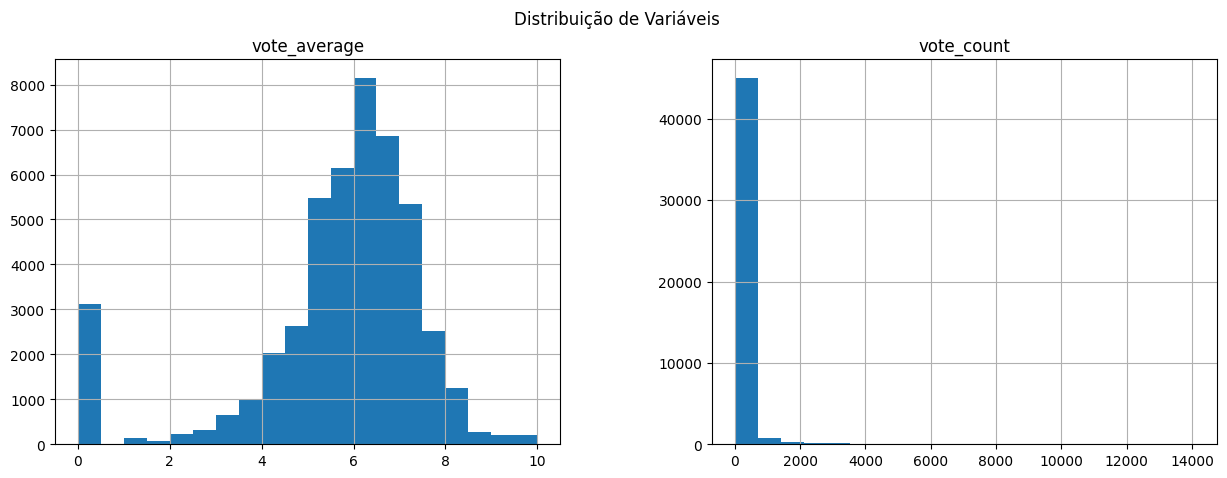

In [ ]:
# Visualizando distribuições
plt.figure(figsize=(10, 6))
dados_filmes[['vote_average', 'vote_count', 'popularity']].hist(bins=20, figsize=(15, 5))
plt.suptitle("Distribuição de Variáveis")
plt.show()

Os histogramas exibem a distribuição das variáveis **vote_average** (nota média) e **vote_count** (número de votos) presentes nos dados dos filmes.

**Gráfico 1: vote_average**
- A maioria dos filmes tem uma nota média entre 5 e 7. Poucos filmes possuem notas muito baixas (próximas a 0) ou muito altas (próximas a 10). Isso indica que as avaliações tendem a se concentrar no meio da escala, provavelmente devido ao comportamento natural de distribuição das notas dos usuários.

**Gráfico 2: vote_count**
- A maior parte dos filmes tem um número baixo de votos (próximo de zero). Poucos filmes têm um número muito alto de votos, como milhares ou até mais de 10 mil. Isso é esperado, pois grandes sucessos (blockbusters) tendem a atrair mais atenção e votos, enquanto a maioria dos filmes recebe um número limitado de avaliações.

A concentração de notas em uma faixa intermediária indica que os usuários tendem a evitar extremos nas avaliações.

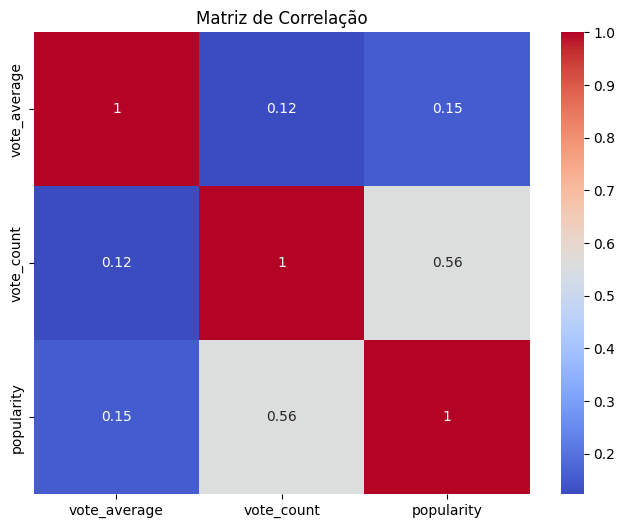

In [ ]:
# Calculando a matriz de correlação
correlation_matrix = dados_filmes[['vote_average', 'vote_count', 'popularity']].corr()

# Visualizando como gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True, cmap='coolwarm',
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns
)
plt.title("Matriz de Correlação")
plt.show()

**vote_average e vote_count (0.12):** Isso significa que há pouca relação direta entre a quantidade de votos recebidos e a nota média do filme. Filmes mais votados não necessariamente possuem notas mais altas.

**vote_average e popularity (0.15):** Filmes populares tendem a ter uma nota média ligeiramente maior, mas essa relação é muito pequena. A popularidade não é um indicador forte da qualidade percebida.

**vote_count e popularity (0.56):**
Há uma relação moderada entre o número de votos recebidos e a popularidade do filme. Filmes mais populares geralmente atraem mais votos, o que é esperado.

- As avaliações médias dos filmes (vote_average) parecem ser independentes da quantidade de votos ou popularidade. Isso pode indicar que os usuários avaliam filmes populares de forma semelhante aos menos populares.

- A popularidade está moderadamente associada ao número de votos. Filmes populares têm mais alcance, atraindo mais avaliações.
Impacto em Sistemas de Recomendação:

- Usar apenas popularidade ou número de votos para recomendar filmes pode levar a resultados enviesados. É importante combinar métricas para uma recomendação mais equilibrada.

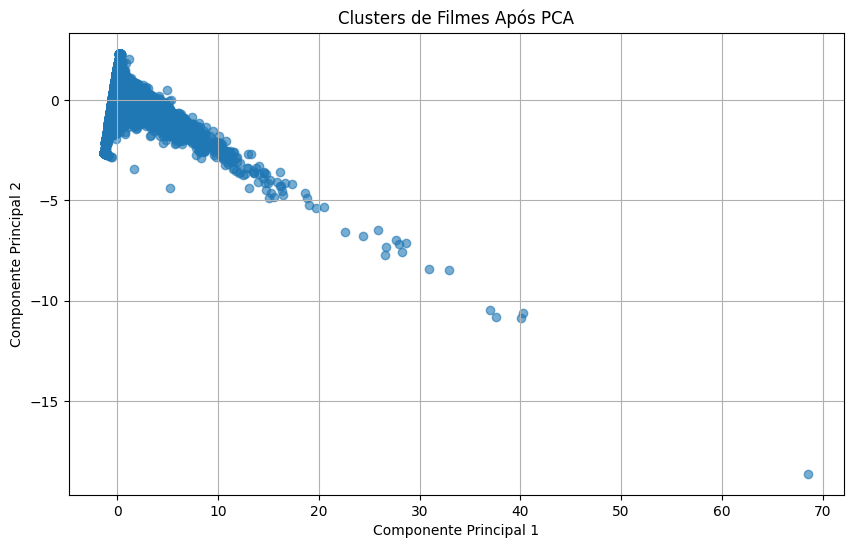

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Garantindo que popularity, vote_average e vote_count sejam numéricos
for col in ['popularity', 'vote_average', 'vote_count']:
    dados_filmes[col] = pd.to_numeric(dados_filmes[col], errors='coerce')

# Removendo linhas com valores ausentes após a conversão
dados_filmes = dados_filmes.dropna(subset=['popularity', 'vote_average', 'vote_count'])

# Normalizando os dados
scaler = StandardScaler()
dados_numericos = dados_filmes[['vote_average', 'vote_count', 'popularity']]  # Seleção de colunas numéricas
dados_escalonados = scaler.fit_transform(dados_numericos)

# Aplicando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dados_escalonados)

# Visualizando os componentes principais
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, cmap='viridis')
plt.title("Clusters de Filmes Após PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()


- Nesse caso, o O PCA projeta os dados originais (com três variáveis: **vote_average**, **vote_count**, e **popularity**) em um novo sistema de coordenadas com componentes principais.

- Esses componentes principais são combinações lineares das variáveis originais, ordenadas de modo que o primeiro componente explica a maior variação dos dados, e o segundo componente explica a segunda maior variação, e assim por diante.

Nesse sentido, filmes populares com muitas avaliações e altas notas (provavelmente blockbusters) estão distantes da origem, enquanto filmes com poucas avaliações e menor popularidade estão mais próximos da origem.

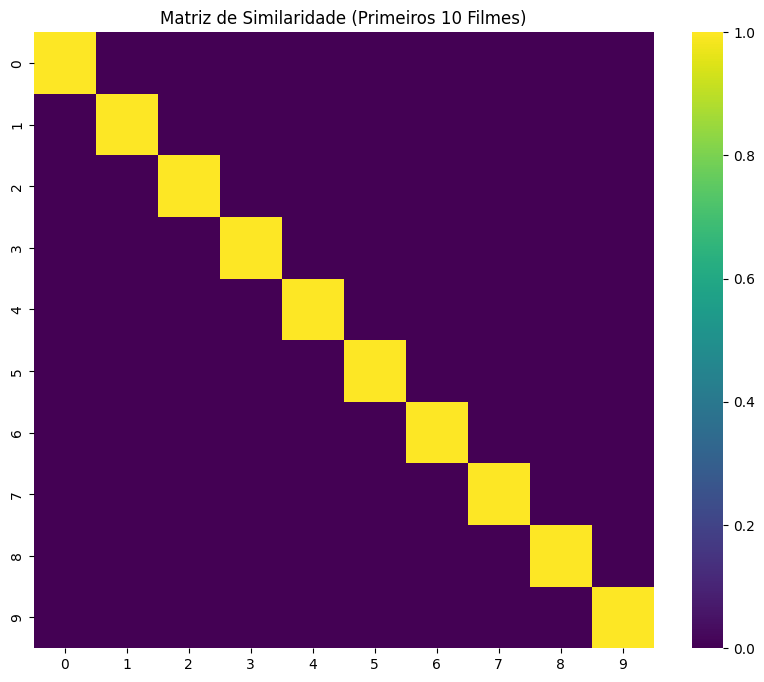

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Criando vetores TF-IDF para títulos dos filmes
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(dados_filmes['title'].fillna(''))

# Calculando similaridade de cosseno
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Exibindo parte da matriz de similaridade
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:10, :10], cmap='viridis')
plt.title("Matriz de Similaridade (Primeiros 10 Filmes)")
plt.show()

- A matriz de similaridade baseada nos títulos dos 10 primeiros filmes revela que há pouca similaridade entre os títulos.

- Este resultado implica que, para recomendar filmes com base em semelhança, seria necessário considerar outras variáveis, como gênero, avaliação ou popularidade, já que **os títulos sozinhos não fornecem informações suficientes para identificar relações significativas** neste subconjunto.








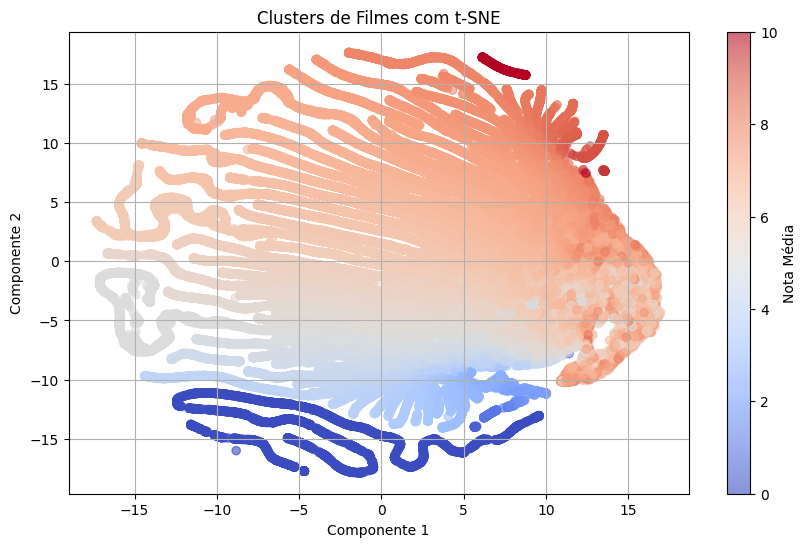

In [ ]:
from sklearn.manifold import TSNE

# Reduzindo para 2D usando t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(dados_escalonados)

# Visualizando os clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dados_filmes['vote_average'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Nota Média')
plt.title("Clusters de Filmes com t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

**negrito**- A visualização com t-SNE reduz os dados a duas dimensões, preservando relações não lineares, e colore os pontos com base na nota média dos filmes. Observa-se que filmes com notas **médias altas** (vermelho) formam pequenos agrupamentos dispersos, indicando características distintas, enquanto filmes com **notas baixas** (azul) tendem a se concentrar em regiões mais definidas.

- Isso sugere que filmes altamente avaliados são mais variados em suas características, enquanto os de baixa avaliação possuem padrões mais homogêneos.

- O t-SNE evidencia que há alguma separação entre filmes de notas diferentes, mas também sobreposição significativa, indicando que outros fatores além da nota podem influenciar essa dispersão.